In [ ]:
/root/hackerday/12_employee_access_need/train.csv
/root/hackerday/12_employee_access_need/test.csv
/root/hackerday/12_employee_access_need/sampleSubmission.csv

In [ ]:
#Import the dataset
#Perform Univariate Analysis
#Data Transformation conversion
#prepare model data
#select model
#apply model
#evaluate results

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline

In [4]:
trdata = pd.read_csv("/root/hackerday/12_employee_access_need/train.csv")
print trdata.head()

   ACTION  RESOURCE  MGR_ID  ROLE_ROLLUP_1  ROLE_ROLLUP_2  ROLE_DEPTNAME  \
0       1     39353   85475         117961         118300         123472   
1       1     17183    1540         117961         118343         123125   
2       1     36724   14457         118219         118220         117884   
3       1     36135    5396         117961         118343         119993   
4       1     42680    5905         117929         117930         119569   

   ROLE_TITLE  ROLE_FAMILY_DESC  ROLE_FAMILY  ROLE_CODE  
0      117905            117906       290919     117908  
1      118536            118536       308574     118539  
2      117879            267952        19721     117880  
3      118321            240983       290919     118322  
4      119323            123932        19793     119325  


In [13]:
trdata['ROLE_ROLLUP_2'].value_counts().head()

118300    4424
118343    3945
118327    2641
118225    2547
118386    1796
Name: ROLE_ROLLUP_2, dtype: int64

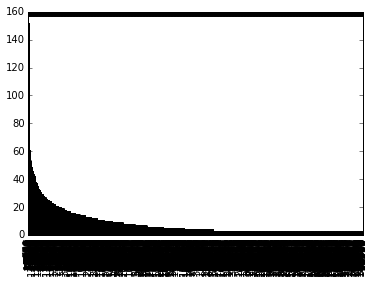

In [9]:
trdata['MGR_ID'].value_counts().plot(kind='bar')

In [22]:
from numpy import array
from sklearn import metrics, linear_model
from sklearn.cross_validation import KFold
from scipy import sparse
from itertools import combinations


In [23]:
import numpy as np
import pandas as pd
import sys
import random
import time

In [24]:
def dict_encode(encoding, value):
    if not value in encoding:
        encoding[value] = {'code': len(encoding)+1, 'count': 0}
    enc = encoding[value]
    enc['count'] += 1
    encoding[value] = enc

In [25]:
def dict_decode(encoding, value, min_occurs):
    enc = encoding[value]
    if enc['count'] < min_occurs:
        return -1
    else:
        return enc['code']

In [26]:
def group_data(data, degree, min_occurs):
    """ 
    numpy.array -> numpy.array
    
    Groups all columns of data into all combinations of degree
    """
    m, n = data.shape
    encoding = dict()
    for indexes in combinations(range(n), degree):
        for v in data[:, indexes]:
            dict_encode(encoding, tuple(v))
    new_data = []
    for indexes in combinations(range(n), degree):
        new_data.append([dict_decode(encoding, tuple(v), min_occurs) for v in data[:, indexes]])
    return array(new_data).T

In [19]:
def one_hot_encoder(data, keymap=None):
    """
     one_hot_encoder takes data matrix with categorical columns and
     converts it to a sparse binary matrix.
     
     Returns sparse binary matrix and keymap mapping categories to indicies.
     If a keymap is supplied on input it will be used instead of creating one
     and any categories appearing in the data that are not in the keymap are
     ignored
     """
    if keymap is None:
        keymap = []
        for col in data.T:
            uniques = set(list(col))
            keymap.append(dict((key, i) for i, key in enumerate(uniques)))
    total_pts = data.shape[0]
    outdat = []
    for i, col in enumerate(data.T):
        km = keymap[i]
        num_labels = len(km)
        spmat = sparse.lil_matrix((total_pts, num_labels))
        for j, val in enumerate(col):
            if val in km:
                spmat[j, km[val]] = 1
        outdat.append(spmat)
    outdat = sparse.hstack(outdat).tocsr()
    return outdat, keymap

In [27]:
def create_test_submission(filename, prediction):
    content = ['id,ACTION']
    for i, p in enumerate(prediction):
        content.append('%i,%f' % (i + 1, p))
    f = open(filename, 'w')
    f.write('\n'.join(content))
    f.close()
    print('Saved')

In [28]:
def cv_loop(X, y, model, N, seed):
    mean_auc = 0.
    k_fold = KFold(len(y), N, indices=True, shuffle=True,
                   random_state=seed)
    for train_ix, test_ix in k_fold:
        model.fit(X[train_ix], y[train_ix])
        preds = model.predict_proba(X[test_ix])[:, 1]
        auc = metrics.auc_score(y[test_ix], preds)
        #print("AUC (fold %d/%d): %f" % (i + 1, N, auc))
        mean_auc += auc
    return mean_auc / N

In [ ]:
def main(train, test, submit, seed, min_occurs, good_features):

    start_time = time.time()
    print("Reading train dataset...")
    train_data = pd.read_csv("/root/hackerday/12_employee_access_need/train.csv")
    #print(train_data.head())

    print("Reading test dataset...")
    test_data = pd.read_csv("/root/hackerday/12_employee_access_need/test.csv")
    #print(test_data.head())

    all_data = np.vstack((train_data.ix[:, 1:], test_data.ix[:, 1:]))

    num_train = np.shape(train_data)[0]
    # Transform data
    print("Transforming data (%i instances)..." % num_train)
    d_2 = group_data(all_data, degree=2, min_occurs=min_occurs)
    d_3 = group_data(all_data, degree=3, min_occurs=min_occurs)
    d_4 = group_data(all_data, degree=4, min_occurs=min_occurs)
    d_5 = group_data(all_data, degree=5, min_occurs=min_occurs)
    d_6 = group_data(all_data, degree=6, min_occurs=min_occurs)
    d_7 = group_data(all_data, degree=7, min_occurs=min_occurs)

    y = array(train_data.ACTION)
    #X_train_all = np.hstack((all_data[:num_train], d_2[:num_train], d_3[:num_train],
    #                         d_4[:num_train], d_7[:num_train]))
    #X_test_all = np.hstack((all_data[num_train:], d_2[num_train:], d_3[num_train:],
    #                        d_4[num_train:], d_7[num_train:]))
    X_train_all = np.hstack((all_data[:num_train], d_2[:num_train], d_3[:num_train], d_4[:num_train],
                             d_5[:num_train], d_6[:num_train], d_7[:num_train]))
    X_test_all = np.hstack((all_data[num_train:], d_2[num_train:], d_3[num_train:], d_4[num_train:],
                            d_5[num_train:], d_6[num_train:], d_7[num_train:]))
    num_features = X_train_all.shape[1]
    print("Total number of categorical features %i" % num_features)

    rnd = random.Random()
    rnd.seed(seed*num_features)

    model = linear_model.LogisticRegression()
    model.C = 0.5 + rnd.random()*3.5
    print("Logistic C parameter: %f" % model.C)

    # Xts holds one hot encodings for each individual feature in memory
    # speeding up feature selection 
    Xts = [one_hot_encoder(X_train_all[:, [i]])[0] for i in range(num_features)]

    print("Performing aproximate greedy feature selection...")
    N = 10
    if good_features is None:
        score_hist = []
        good_features = set([])

        # Feature selection loop
        f_remain = range(len(Xts))
        cur_best_score = -1
        cur_best_score_thres = 1.0
        while len(score_hist) < 2 or score_hist[-1][0] > score_hist[-2][0]:
            scores = []
            f_shuff = list(f_remain)
            rnd.shuffle(f_shuff)
            n_thres = 0.3679*len(f_remain)
            i = 0
            iter_best_score = -1
            for f in f_shuff:

                i += 1
                feats = list(good_features) + [f]
                Xt = sparse.hstack([Xts[j] for j in feats]).tocsr()
                score = cv_loop(Xt, y, model, N, seed)
                if score < (cur_best_score*cur_best_score_thres):
                    f_remain.remove(f)
                    print("Discarded: %i (AUC = %f) " % (f, score))
                else:
                    scores.append((score, f))
                    if score > iter_best_score:
                        iter_best_score = score
                        if i > n_thres and iter_best_score > cur_best_score:
                            print("Early stop on iter %i" % i)
                            break
            if len(scores) > 0:
                best_score = sorted(scores)[-1]
                f_remain.remove(best_score[1])
                if best_score[0] > cur_best_score:
                    good_features.add(best_score[1])
                    score_hist.append(best_score)
                    cur_best_score = best_score[0]
                print("Current features: %s (AUC = %f, remain = %i) " %
                      (list(good_features), best_score[0], len(f_remain)))
            else:
                break

    good_features = sorted(list(good_features))
    print("Selected features %s" % good_features)

    print("Performing hyperparameter selection...")
    # Hyperparameter selection loop
    Xt = sparse.hstack([Xts[j] for j in good_features]).tocsr()
    score_hist = []
    score = cv_loop(Xt, y, model, N, seed)
    score_hist.append((score, model.C))
    
    Cvals = np.logspace(-3, 4, 20, base=2)
    for C in Cvals:
        model.C = C
        score = cv_loop(Xt, y, model, N, seed)
        score_hist.append((score, C))
        print("C: %f Mean AUC: %f" % (C, score))
    model.C = sorted(score_hist)[-1][1]
    score = sorted(score_hist)[-1][0]
    print("Best (C, AUC): (%f, %f)" % (model.C, score))

    print("Performing One Hot Encoding on entire dataset...")
    Xt = np.vstack((X_train_all[:, good_features], X_test_all[:, good_features]))
    Xt, keymap = one_hot_encoder(Xt)
    X_train = Xt[:num_train]
    X_test = Xt[num_train:]

    print("Training full model...")
    model.fit(X_train, y)

    print("Making prediction and saving results...")
    preds = model.predict_proba(X_test)[:, 1]
    create_test_submission(submit, preds)
    print("Total time %f minutes" % ((time.time() - start_time)/60.0))


if __name__ == "__main__":

    name_def = '11.1'
    args = {'train': 'lr/data.lr.' + name_def + '.tr.csv',
            'test': 'lr/data.lr.' + name_def + '.test.csv',
            'submit': 'lr/data.lr.' + name_def + '.test.pred.csv',
            'seed': 123,
            'min_occurs': 3,
            'good_features': []}
    if len(sys.argv) >= 2:
        args['train'] = sys.argv[1]

    if len(sys.argv) >= 3:
        args['test'] = sys.argv[2]

    if len(sys.argv) >= 4:
        args['submit'] = sys.argv[3]

    if len(sys.argv) >= 5:
        args['seed'] = int(sys.argv[4])

    if len(sys.argv) >= 6:
        args['min_occurs'] = int(sys.argv[5])

    if len(sys.argv) >= 7:
        args['good_features'] = [int(val) for val in sys.argv[6].split(',')]

    if len(args['good_features']) == 0:
        args['good_features'] = None

    print(args)
    main(**args)
                            

{'submit': 'lr/data.lr.11.1.test.pred.csv', 'train': '-f', 'good_features': None, 'test': '/home/ubuntu/.local/share/jupyter/runtime/kernel-404c5bd7-dfd1-418d-a845-1a214ec43e49.json', 'seed': 123, 'min_occurs': 3}
Reading train dataset...
Reading test dataset...
Transforming data (32769 instances)...